In [4]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import plotly.express as px

In [8]:
from summer2 import CompartmentalModel, Stratification
from summer2.parameters import Parameter
from summer2.functions import get_piecewise_scalar_function

**Model 2: SEIQR (with Age Stratification)**

In [14]:
def build_model():
    m = CompartmentalModel([0,100], ["S","E","I","Q","R"],"I",ref_date=datetime(2020,6,1))
    m.set_initial_population({"S": 13781001.0, "E": 832.0 , "I": 1153.0, "Q": 3622.0, "R": 14178.0})
    m.add_infection_frequency_flow("infection", get_piecewise_scalar_function([Parameter("breakpt1"),Parameter("breakpt2")], [Parameter("rate1"),Parameter("rate2"),Parameter("rate3")]),"S","E") 
    m.add_transition_flow("progression", 0.2,"E","I")
    m.add_transition_flow("notification", Parameter("detection_rate"),"I","Q")
    m.add_transition_flow("recovery_from_Q", 0.0714,"Q","R") 
    m.add_transition_flow("recovery__from_I", 0.0714,"I","R") 
    m.request_output_for_flow("infection", "infection")
    m.request_output_for_flow("notification", "notification")
    m.request_output_for_compartments(name="active", compartments=["Q"])
    return m

In [15]:
m = build_model()

/var/folders/58/qy67y27x0jsd0h0bx4dmp2yw0000gn/T/ipykernel_4253/3232228000.py:4: DeprecationWarning:

This method is deprecated and scheduled for removal, use get_piecewise_function instead



In [16]:
parameters = {"breakpt1": 20, "breakpt2": 30, "rate1": 0.3, "rate2": 0.2, "rate3": 0.25, "detection_rate": 0.1}

In [17]:
m.run(parameters)

<Axes: >

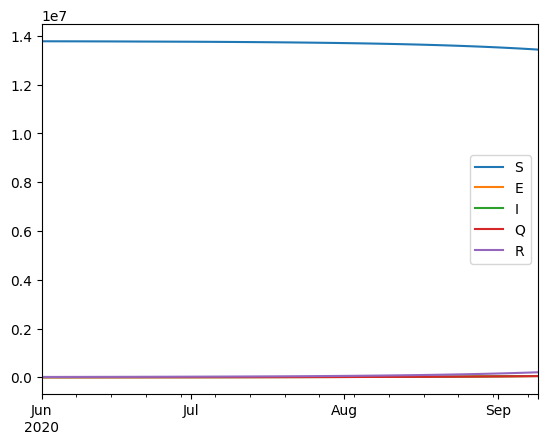

In [18]:
m.get_outputs_df().plot()

<Axes: >

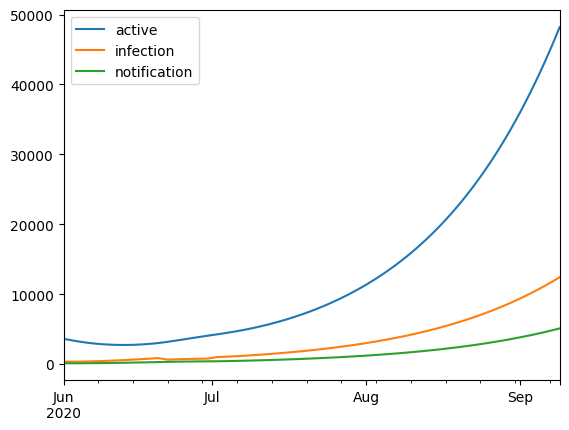

In [19]:
m.get_derived_outputs_df().plot()

**Stratification**

In [9]:
strata = [str(n) for n in range(0,80,5)]
strat = Stratification(name="age", strata=strata, compartments=["S", "E", "I", "Q", "R"])

In [11]:
mixing_matrix = pd.read_pickle("PHL_matrices.pkl", compression='infer')
age_mixing_matrix = mixing_matrix["all_locations"]

In [12]:
# Let's have a look at the matrix using plotly express
print(age_mixing_matrix.shape)
px.imshow(age_mixing_matrix)

(16, 16)


In [13]:
strat.set_mixing_matrix(age_mixing_matrix)

In [22]:
m_strat = build_model()
m_strat.stratify_with(strat)

/var/folders/58/qy67y27x0jsd0h0bx4dmp2yw0000gn/T/ipykernel_4253/3232228000.py:4: DeprecationWarning:

This method is deprecated and scheduled for removal, use get_piecewise_function instead



In [25]:
m_strat.run(parameters)

<Axes: >

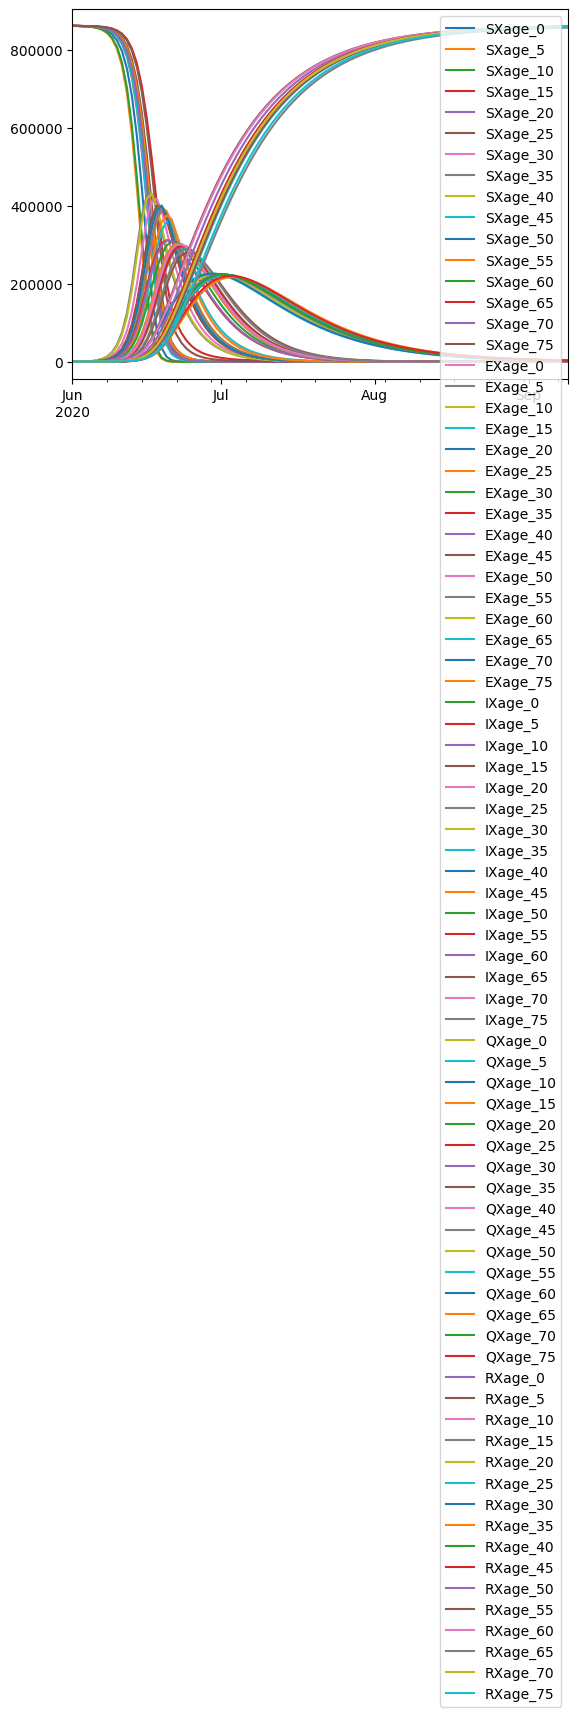

In [27]:
m_strat.get_outputs_df().plot()

<Axes: >

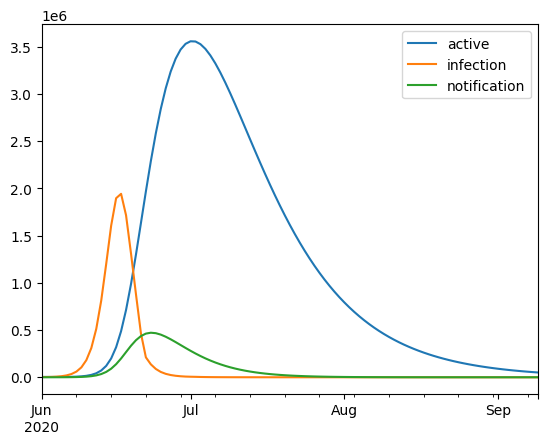

In [28]:
m_strat.get_derived_outputs_df().plot()

**Target Data**

In [29]:
df=pd.read_excel(io='InfectionsData_060120_093020.xlsx',index_col=0)
notification_data = df["7-DAY MA"]

In [30]:
notification_data

DATE
2020-06-01     326.000000
2020-06-02     314.571429
2020-06-03     314.714286
2020-06-04     306.000000
2020-06-05     230.000000
                 ...     
2020-09-26    1036.285714
2020-09-27     997.285714
2020-09-28     984.428571
2020-09-29     989.285714
2020-09-30     943.571429
Name: 7-DAY MA, Length: 122, dtype: float64

In [31]:
notification_data_cal = notification_data[15:61]

<Axes: xlabel='DATE'>

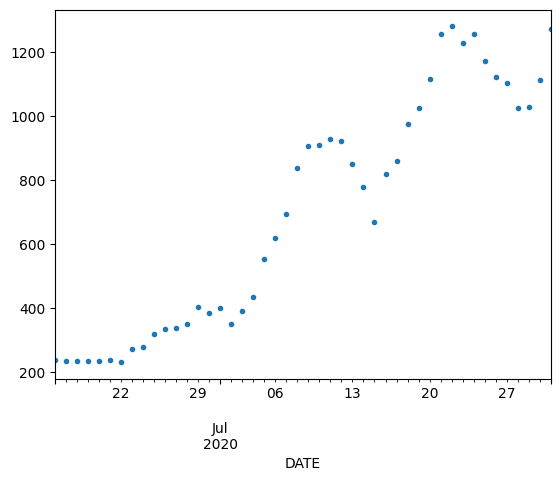

In [32]:
notification_data_cal.plot(style='.')

**Calibration**

In [33]:
# Targets represent data we are trying to fit to
from estival import targets as est

# We specify parameters using (Bayesian) priors
from estival import priors as esp

# Finally we combine these with our summer2 model in a BayesianCompartmentalModel (BCM)
from estival.model import BayesianCompartmentalModel

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [34]:
targets = [
    #est.NormalTarget("notification", notification_data_cal, np.std(notification_data_cal) * 0.1)
    est.TruncatedNormalTarget("notification", notification_data_cal, (0.0,np.inf),
        esp.UniformPrior("notification_dispersion",(0.1, notification_data_cal.max()*0.1)))
]

In [35]:
priors = [
    esp.UniformPrior("breakpt1", (30,45)),
    esp.UniformPrior("breakpt2", (45,61)),
    esp.UniformPrior("rate1", (0.1,0.5)),
    esp.UniformPrior("rate2", (0.1,0.5)),
    esp.UniformPrior("rate3", (0.1,0.5)),
    esp.UniformPrior("detection_rate", (0.1,1)),
]

In [36]:
defp = {"breakpt1": 30, "breakpt2": 30, "rate1": 0.2, "rate2": 0.2, "rate3": 0.2, "detection_rate":0.2}

In [37]:
bcm = BayesianCompartmentalModel(m, defp, priors, targets)
from estival.wrappers import pymc as epm
import pymc as pm

In [38]:
with pm.Model() as model:

    # This is all you need - a single call to use_model
    variables = epm.use_model(bcm)

    # The log-posterior value can also be output, but may incur additional overhead
    # Use jacobian=False to get the unwarped value (ie just the 'native' density of the priors
    # without transformation correction factors)
    # pm.Deterministic("logp", model.logp(jacobian=False))

    # Now call a sampler using the variables from use_model
    # In this case we use the Differential Evolution Metropolis sampler
    # See the PyMC docs for more details
    idata = pm.sample(step=[pm.DEMetropolis(variables)], draws=12000, tune=0,cores=4,chains=12)

Population sampling (12 chains)
DEMetropolis: [breakpt1, breakpt2, rate1, rate2, rate3, detection_rate, notification_dispersion]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.

Sampling 12 chains for 0 tune and 12_000 draw iterations (0 + 144_000 draws total) took 68 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


**Visualizing Outputs**

In [39]:
import arviz as az

In [40]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
breakpt1,37.970,4.217,31.269,44.999,0.111,0.079,1303.0,1087.0,1.01
breakpt2,52.850,4.542,45.879,60.754,0.117,0.083,1461.0,2053.0,1.01
rate1,0.369,0.062,0.273,0.480,0.003,0.002,401.0,262.0,1.03
rate2,0.340,0.092,0.188,0.500,0.003,0.002,795.0,1154.0,1.02
rate3,0.287,0.107,0.102,0.463,0.003,0.002,1330.0,2199.0,1.01
detection_rate,0.205,0.089,0.101,0.294,0.006,0.005,308.0,176.0,1.04
notification_dispersion,103.074,18.457,69.714,128.031,0.490,0.357,1218.0,1612.0,1.01


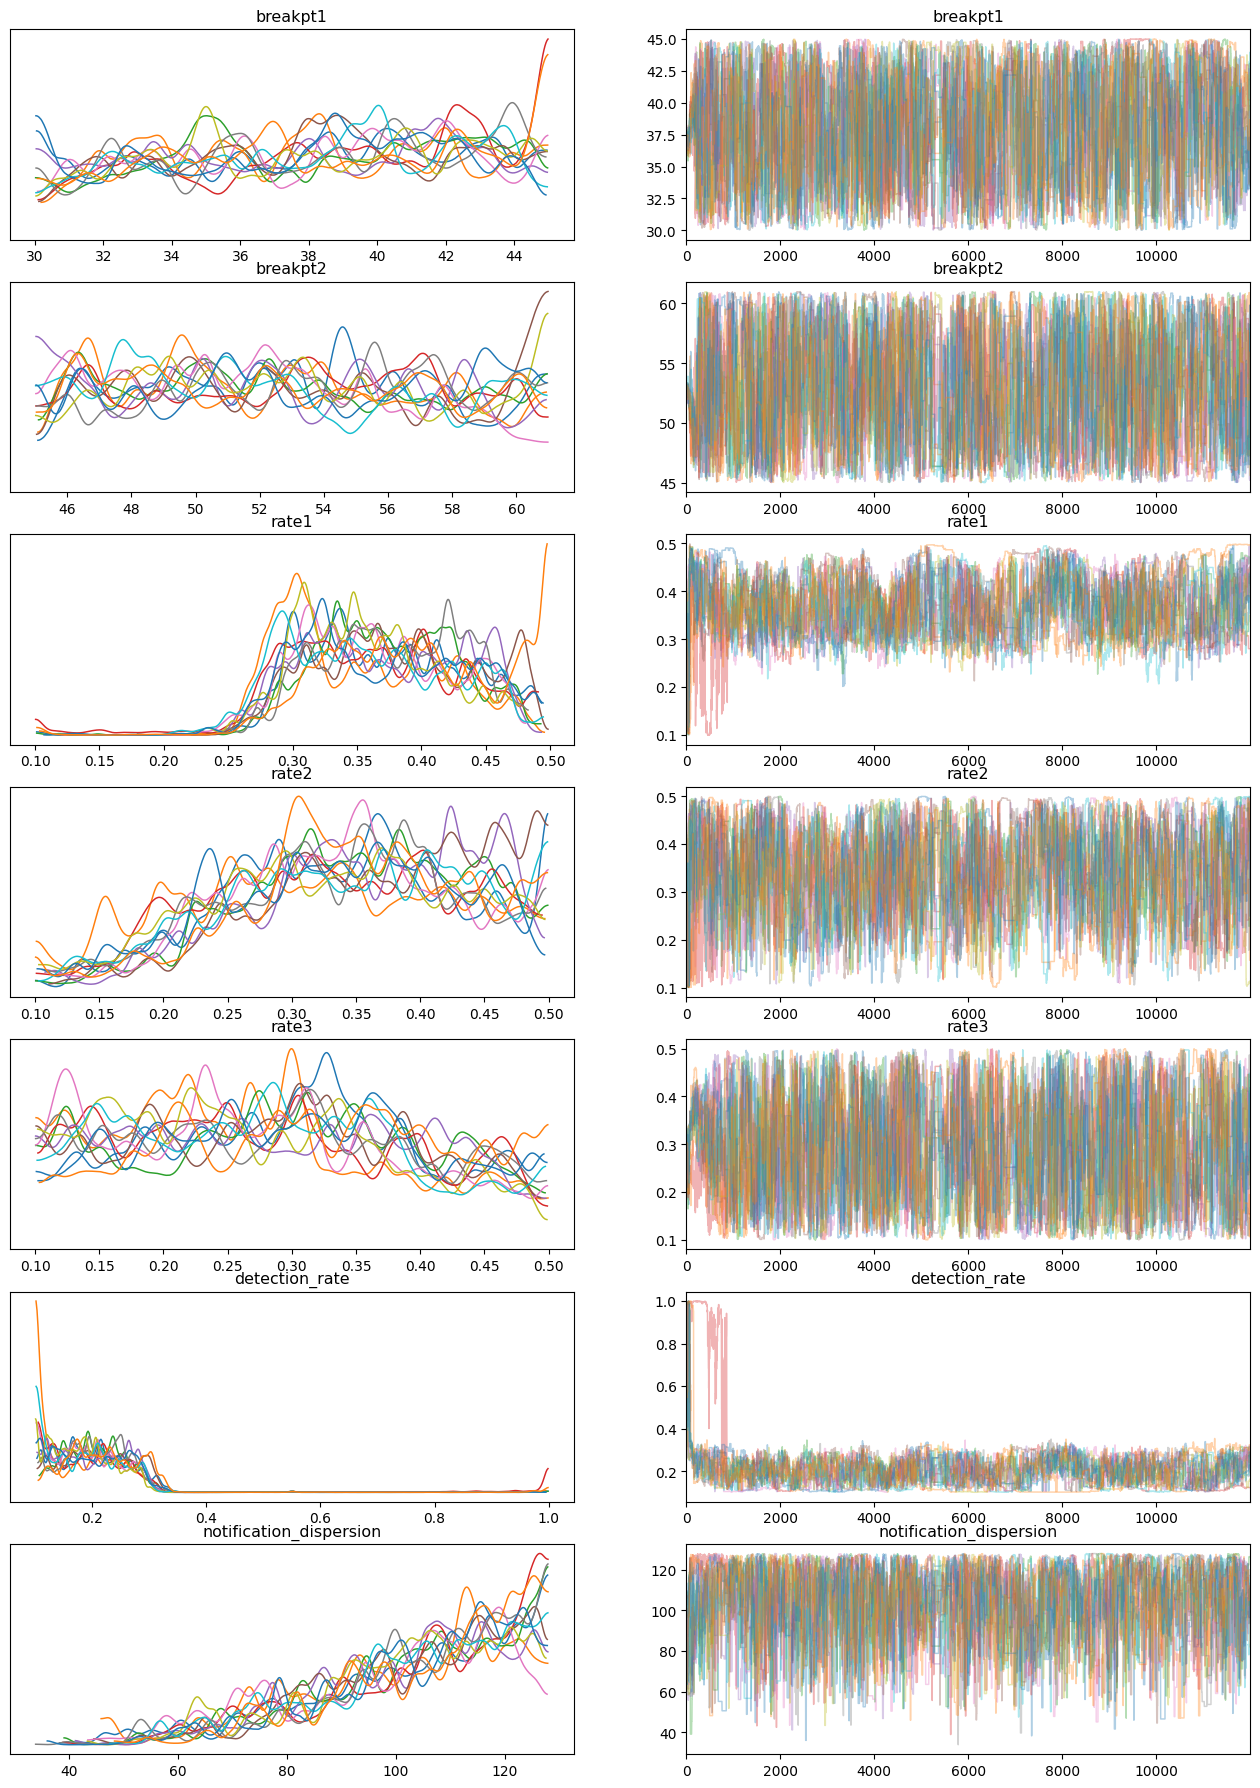

In [41]:
az.plot_trace(idata, figsize=(16,3.2*len(idata.posterior)),compact=False);#, lines=[("m", {}, mtrue), ("c", {}, ctrue)]);

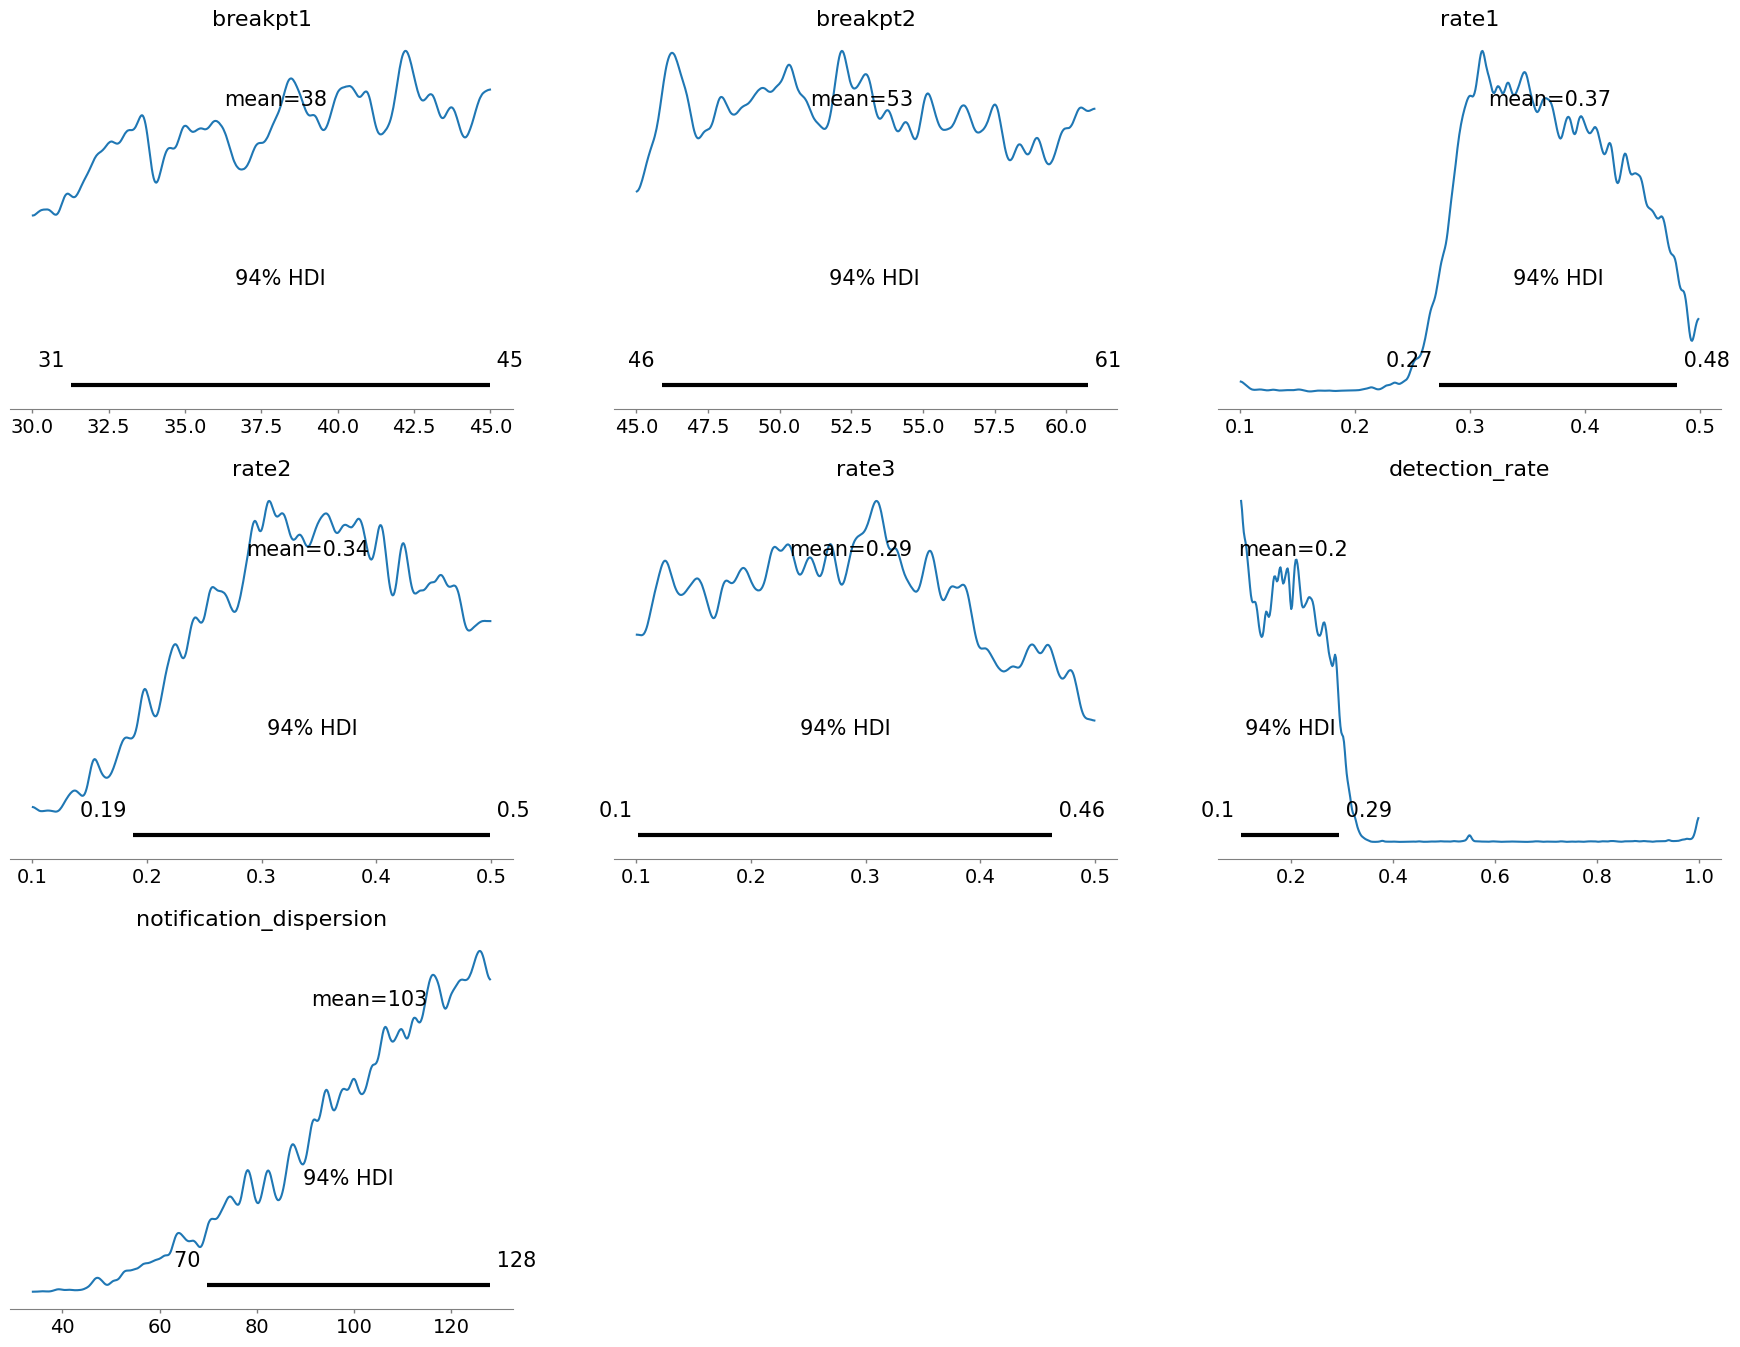

In [42]:
az.plot_posterior(idata);

**Obtaining Likelihood**

In [43]:
from estival.sampling.tools import likelihood_extras_for_idata

In [44]:
likelihood_df = likelihood_extras_for_idata(idata, bcm)

<Axes: xlabel='draw'>

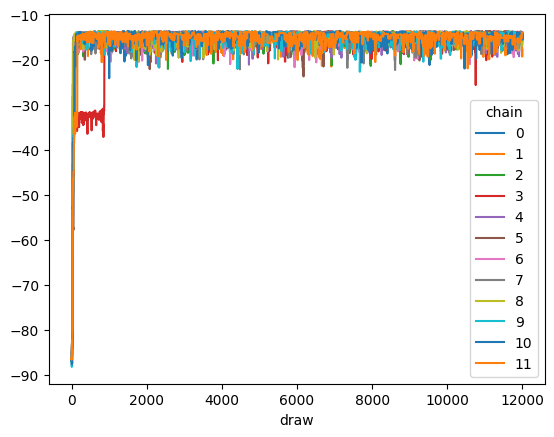

In [45]:
ldf_pivot = likelihood_df.reset_index(level="chain").pivot(columns=["chain"])

ldf_pivot["logposterior"].plot()

In [46]:
# Sort this DataFrame by logposterior to obtain the MAP index
ldf_sorted = likelihood_df.sort_values(by="logposterior",ascending=False)

# Extract the parameters from the calibration samples
map_params = idata.posterior.to_dataframe().loc[ldf_sorted.index[0]].to_dict()

map_params

{'breakpt1': 44.31835096820823,
 'breakpt2': 48.083458883458874,
 'rate1': 0.32202390797241376,
 'rate2': 0.3696491648245267,
 'rate3': 0.18032498813955178,
 'detection_rate': 0.14603515151718865,
 'notification_dispersion': 108.22260620847602}

In [47]:
bcm.loglikelihood(**map_params), ldf_sorted.iloc[0]["loglikelihood"]

(Array(-6.05821439, dtype=float64), -6.058214388069635)

In [48]:
map_res = bcm.run(map_params)

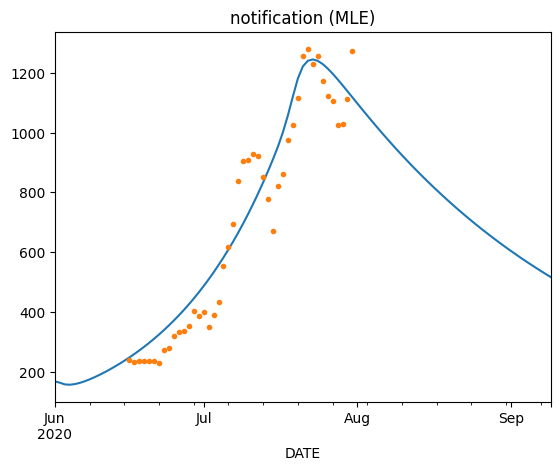

In [49]:
variable = "notification"

pd.Series(map_res.derived_outputs[variable]).plot(title = f"{variable} (MLE)")
bcm.targets[variable].data.plot(style='.');

**Compare with Actual Data for August 2020**

<Axes: title={'center': 'notification (MLE)'}, xlabel='DATE'>

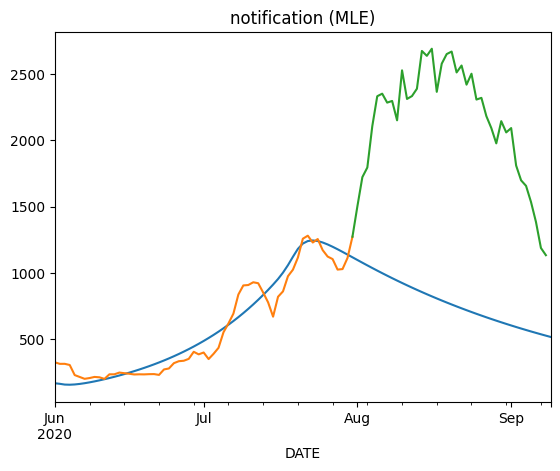

In [50]:
pd.Series(map_res.derived_outputs[variable]).plot(title = f"{variable} (MLE)")
notification_data[:61].plot()
notification_data[60:100].plot()

**Uncertainty Sampling**

In [51]:
sample_idata = az.extract(idata, num_samples = 400)
samples_df = sample_idata.to_dataframe().drop(columns=["chain","draw"])

In [52]:
from estival.utils.parallel import map_parallel

In [53]:
def run_sample(idx_sample):
    idx, params = idx_sample
    return idx, bcm.run(params)

In [54]:
sample_res = map_parallel(run_sample, samples_df.iterrows(), n_workers=4)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [55]:
import xarray as xr

In [56]:
xres = xr.DataArray(np.stack([r.derived_outputs for idx, r in sample_res]),
                    dims=["sample","time","variable"])
xres = xres.assign_coords(sample=sample_idata.coords["sample"],
                          time=map_res.derived_outputs.index, variable=map_res.derived_outputs.columns)

In [57]:
# Set some quantiles to calculate
quantiles = (0.01,0.05,0.25,0.5,0.75,0.95,0.99)

# Generate a new DataArray containing the quantiles
xquantiles = xres.quantile(quantiles,dim=["sample"])

In [58]:
# Extract these values to a pandas DataFrame for ease of plotting

uncertainty_df = xquantiles.to_dataframe(name="value").reset_index().set_index("time").pivot(columns=("variable","quantile"))["value"]

<Axes: title={'center': 'notification'}, xlabel='DATE'>

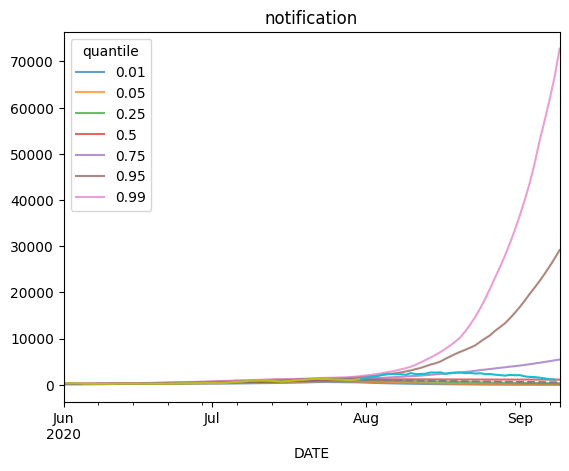

In [59]:
variable = "notification"

fig = uncertainty_df[variable].plot(title=variable,alpha=0.7)
pd.Series(map_res.derived_outputs[variable]).plot(style='--')
notification_data[:61].plot()
notification_data[60:100].plot()